# Topic Modeling

## <span style="color:orange">Modeling Amazon Reviews

### Imports

In [1]:
import nltk
from nltk import FreqDist
nltk.download('stopwords') # run this one time
#python -m spacy download en # run in a console as administrator
import pandas as pd
import numpy as np
import re
import spacy
import gensim
from gensim import corpora
import os.path #relative path import
from sklearn.feature_extraction.text import TfidfVectorizer #lSA
from sklearn.decomposition import TruncatedSVD
import os
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from sklearn.preprocessing import Normalizer
import umap

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NB24634\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\NB24634\AppData\Local\Continuum\miniconda3\envs\master_thesis\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

def lemmatization(texts, tags=['ADV', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
         doc = nlp(" ".join(sent)) 
         output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

### T2: Data Quality

#### Load file

In [3]:
#use this to read the sampled file
df_sampled = pd.read_excel('sample_final_review.xlsx', sheet_name="Sheet1")
df_sampled = df_sampled.sample(frac=0.001, random_state=1) #working with 0.01% of the total dataset 
df_sampled.head()


,category,date,stars,title,review,product,word_count
8157,technology,"May 29, 2016",4,Hot hot hot!,"A fantastic product, except for the heat. You ...",25_Pen_drive,24
50547,Amazon product,"on April 4, 2018",2,Unlock button doesn't work.,"It's not that I hate the product, because the ...",kindlePaperWhite,59
49770,Amazon product,"on June 8, 2018",5,Five Stars,Love IT,fireStick,2
91883,Amazon product,"on April 26, 2018",5,Five Stars,Love it,echoDot,2
5702,technology,"April 26, 2018",4,Doesn't stay on small ears very well \xf0\x9f\...,I have little ears and can never get any ear b...,21_phones,54


In [4]:
df_sampled.shape[0]

73

### Improving Results from previous analysis

### T4: DOCUMENT REPRESENTATION

#### 1. Latent Semantic Analysis (LSA)

In [5]:
### In the last analysis it was seen that the results were not interesting due to the lack of valuable input data. 
### It was needed to remove stop words; and words with less then 3 chars.

In [6]:
stop_words=stopwords.words('english')#import stopwords lib with function words(list of stopwords to remove)

#creating a new column and with reviews without Stop Words.
# remove unwanted characters, numbers and symbols, pontuation
df_sampled['review_modified'] = df_sampled['review'].str.replace("[^a-zA-Z#]", " ")
df_sampled['review_modified'] = df_sampled['review_modified'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

#removing nan to be able to create a tfidf matrix
df_sampled.dropna()

#Removing Stop Words
df_sampled['review_modified'] = [remove_stopwords(r.split()) for r in df_sampled['review_modified']]

#lower_case
df_sampled['review_modified'] = [r.lower() for r in df_sampled['review_modified']]


In [7]:
df_sampled.head()

,category,date,stars,title,review,product,word_count,review_modified
8157,technology,"May 29, 2016",4,Hot hot hot!,"A fantastic product, except for the heat. You ...",25_Pen_drive,24,fantastic product except heat could cook small...
50547,Amazon product,"on April 4, 2018",2,Unlock button doesn't work.,"It's not that I hate the product, because the ...",kindlePaperWhite,59,hate product kindle great like however even mo...
49770,Amazon product,"on June 8, 2018",5,Five Stars,Love IT,fireStick,2,love
91883,Amazon product,"on April 26, 2018",5,Five Stars,Love it,echoDot,2,love
5702,technology,"April 26, 2018",4,Doesn't stay on small ears very well \xf0\x9f\...,I have little ears and can never get any ear b...,21_phones,54,little ears never style headphones ears stay w...


In [8]:
#### analysing data

In [9]:
df_sampled['review_modified'].shape[0]

73

In [10]:
total_words = " ".join(review for review in df_sampled.review_modified)
print("There are {} words in the combination of all review.".format(len(total_words)))

There are 9930 words in the combination of all review.


#### 1. Latent Semantic Analysis (LSA)

In [15]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,1)) #unigrams
reviews_list = df_sampled['review_modified'].tolist()
dtm = tfidf_vectorizer.fit_transform(reviews_list)
lsa_matrix1 = pd.DataFrame(dtm.toarray(),index=reviews_list,columns=tfidf_vectorizer.get_feature_names())
lsa_matrix1

,able,able plug,able plug stick,able sign,able sign connected,able sign netflix,able time,able time different,absolutely,absolutely love,...,year play games,years,years said,years said would,yogurt,yogurt maker,yogurt maker sauteed,youtube,youtube turned,youtube turned plugged
fantastic product except heat could cook small meal thing minutes plugged,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
hate product kindle great like however even months unlock button already work sits husbands desk reads couch reason work,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
love,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
love,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
little ears never style headphones ears stay well wife work great sound quality pretty good listened music hours still died charging,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
these tile mates nonresponsive meaning battery dead thing another tile mate given christmas synched tile phone trouble these sync ting nada nothing,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
easy works advertised,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
price incredible know going great,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
years said would never reader grandmother kindle found clunky hard eyes then tried kindle sold easy read tough eyes clunky great travel home,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.122748,0.122748,0.122748,0.000000,0.000000,0.000000,0.0,0.0,0.0
great alexa cheap control phillips system well tell news weather play pandora really much review said elsewhere great little unit,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [19]:
#analysing
path=r'D:\Profiles\NB24634\Documents\OneDrive - Novabase\ISCTE'
lsa_matrix.to_csv(path+'lsa_matrix_unigram.csv')

In [17]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(2,2)) #bigrams
reviews_list = df_sampled['review_modified'].tolist()
dtm = tfidf_vectorizer.fit_transform(reviews_list)
lsa_matrix2 = pd.DataFrame(dtm.toarray(),index=reviews_list,columns=tfidf_vectorizer.get_feature_names())
lsa_matrix2

,able plug,able sign,able time,absolutely love,absolutely took,accidental steam,account also,account person,across whole,active maybe,...,write home,wrong pressure,wrong this,xfinity cable,yamaha multimedia,yard work,year play,years said,yogurt maker,youtube turned
fantastic product except heat could cook small meal thing minutes plugged,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
hate product kindle great like however even months unlock button already work sits husbands desk reads couch reason work,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
love,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
love,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
little ears never style headphones ears stay well wife work great sound quality pretty good listened music hours still died charging,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
these tile mates nonresponsive meaning battery dead thing another tile mate given christmas synched tile phone trouble these sync ting nada nothing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
easy works advertised,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
price incredible know going great,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
years said would never reader grandmother kindle found clunky hard eyes then tried kindle sold easy read tough eyes clunky great travel home,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.213201,0.000000,0.0
great alexa cheap control phillips system well tell news weather play pandora really much review said elsewhere great little unit,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [20]:
#analysing
path=r'D:\Profiles\NB24634\Documents\OneDrive - Novabase\ISCTE'
lsa_matrix.to_csv(path+'lsa_matrix_bigram.csv')

In [23]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(3,3)) #unigrams
reviews_list = df_sampled['review_modified'].tolist()
dtm = tfidf_vectorizer.fit_transform(reviews_list)
lsa_matrix3 = pd.DataFrame(dtm.toarray(),index=reviews_list,columns=tfidf_vectorizer.get_feature_names())
lsa_matrix3

,able plug stick,able sign connected,able sign netflix,able time different,absolutely love fire,absolutely love understands,absolutely took care,accidental steam burns,account also echo,account person hooked,...,would works router,write home money,wrong pressure cookers,wrong this absolutely,yamaha multimedia receiver,yard work least,year play games,years said would,yogurt maker sauteed,youtube turned plugged
fantastic product except heat could cook small meal thing minutes plugged,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
hate product kindle great like however even months unlock button already work sits husbands desk reads couch reason work,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
love,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
love,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
little ears never style headphones ears stay well wife work great sound quality pretty good listened music hours still died charging,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
these tile mates nonresponsive meaning battery dead thing another tile mate given christmas synched tile phone trouble these sync ting nada nothing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
easy works advertised,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
price incredible know going great,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
years said would never reader grandmother kindle found clunky hard eyes then tried kindle sold easy read tough eyes clunky great travel home,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.218218,0.000000,0.0
great alexa cheap control phillips system well tell news weather play pandora really much review said elsewhere great little unit,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [21]:
#analysing
path=r'D:\Profiles\NB24634\Documents\OneDrive - Novabase\ISCTE'
lsa_matrix.to_csv(path+'lsa_matrix_trigrams.csv')

In [24]:
lsa_matrix3.shape

(73, 1288)

In [ ]:
#analysing
#path=r'D:\Profiles\NB24634\Documents\OneDrive - Novabase\ISCTE'
#lsa_matrix.to_csv(path+'lsa_matrix.csv')

In [ ]:
#type(lsa_matrix)
#lsa_matrix.to_frame()
#sums = lsa_matrix.select_dtypes(pd.np.number).sum().rename('total')

In [ ]:
path=r'D:\Profiles\NB24634\Documents\OneDrive - Novabase\ISCTE'
lsa_matrix.to_csv(path+'lsa_matrix.csv')

#### aplying svd

In [42]:
# Fit LSA. Use algorithm = “randomized” for large datasets
lsa = TruncatedSVD(12, algorithm = 'randomized')
dtm_lsa_model = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa_model)

In [30]:


list_stars = df_sampled['stars'].tolist()
len(list_stars)

X_topics = lsa.fit_transform(dtm)
embedding = umap.UMAP(n_neighbors=15, min_dist=0.5, random_state=12).fit_transform(X_topics)


In [47]:
print(len(lsa.components_))

12


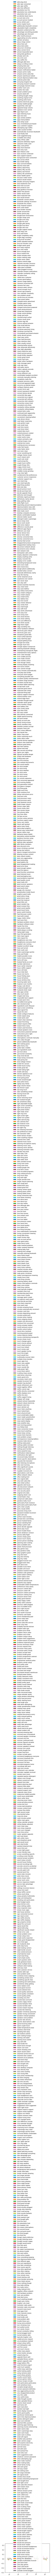

In [28]:
for i, comp in enumerate(lsa.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

In [37]:
plot_test = pd.DataFrame(lsa.components_,index = ["T1","T2", "T3", "T4", "T5","T6", "T7", "T8", "T9", "T10", "T11", "T12"],columns = tfidf_vectorizer.get_feature_names())
plot_test

,able plug stick,able sign connected,able sign netflix,able time different,absolutely love fire,absolutely love understands,absolutely took care,accidental steam burns,account also echo,account person hooked,...,would works router,write home money,wrong pressure cookers,wrong this absolutely,yamaha multimedia receiver,yard work least,year play games,years said would,yogurt maker sauteed,youtube turned plugged
T1,0.013858,0.013858,0.013858,0.082299,0.030922,0.019526,-0.006717,0.002957,0.025087,0.025087,...,-0.006717,-0.007867,0.002957,-0.006717,0.013858,-0.001398,0.007265,-0.006599,0.002081,-0.007867
T2,-0.001190,-0.001190,-0.001190,-0.006008,0.007880,-0.039375,0.036194,-0.004949,0.081758,0.081758,...,0.036194,-0.030780,-0.004949,0.036194,-0.001190,0.037103,0.045289,0.013326,0.022153,-0.030780
T3,-0.005468,-0.005468,-0.005468,-0.004043,-0.021056,-0.104657,-0.028125,-0.001103,0.025814,0.025814,...,-0.028125,0.014070,-0.001103,-0.028125,-0.005468,-0.021085,0.014168,-0.052662,0.028070,0.014070
T4,-0.003697,-0.003697,-0.003697,0.009385,0.058755,0.005296,-0.001836,0.014255,-0.038515,-0.038515,...,-0.001836,-0.015968,0.014255,-0.001836,-0.003697,-0.010308,0.036201,-0.024516,-0.014469,-0.015968
T5,-0.015069,-0.015069,-0.015069,0.110795,-0.027630,-0.145580,-0.039168,-0.005191,0.013548,0.013548,...,-0.039168,-0.030276,-0.005191,-0.039168,-0.015069,0.004692,-0.001790,0.004942,-0.002339,-0.030276
T6,-0.009672,-0.009672,-0.009672,-0.055237,-0.031138,0.019210,0.006105,0.008418,0.001207,0.001207,...,0.006105,0.029937,0.008418,0.006105,-0.009672,0.011990,0.013019,0.015944,-0.002439,0.029937
T7,-0.004218,-0.004218,-0.004218,-0.016992,-0.036143,-0.143157,0.005542,0.007211,-0.002741,-0.002741,...,0.005542,0.006613,0.007211,0.005542,-0.004218,-0.009702,0.063998,0.009677,0.005626,0.006613
T8,0.010389,0.010389,0.010389,-0.023556,-0.004907,0.004409,0.003252,-0.010282,0.009945,0.009945,...,0.003252,-0.009962,-0.010282,0.003252,0.010389,-0.001341,0.025873,0.004968,-0.003419,-0.009962
T9,-0.010107,-0.010107,-0.010107,0.026061,-0.029949,-0.043129,-0.001388,0.021760,0.024419,0.024419,...,-0.001388,0.021011,0.021760,-0.001388,-0.010107,-0.025035,0.041999,-0.018866,-0.004634,0.021011
T10,-0.000085,-0.000085,-0.000085,-0.051992,-0.057910,-0.110164,0.006697,0.001439,-0.029293,-0.029293,...,0.006697,-0.005870,0.001439,0.006697,-0.000085,-0.002893,-0.046181,-0.040725,0.011142,-0.005870


In [31]:
list_embeddings = {'1': [], '2': [], '3': [], '4': [], '5': []}


for index, star in enumerate(list_stars):
    list_embeddings[str(star)].append([embedding[index, 0], embedding[index, 1], star])
    

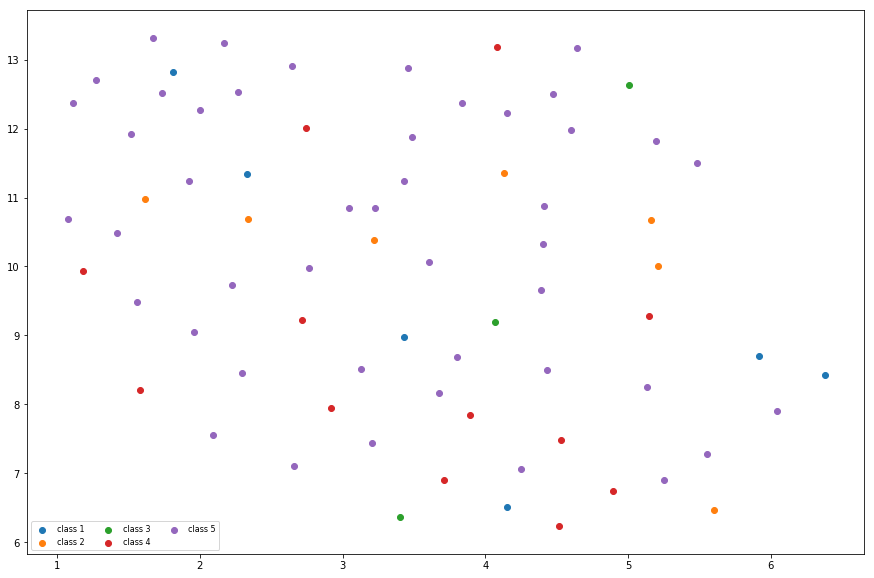

In [32]:
plt.figure(figsize=(15,10))

star_1 = np.array(list_embeddings['1'])
star_2 = np.array(list_embeddings['2'])
star_3 = np.array(list_embeddings['3'])
star_4 = np.array(list_embeddings['4'])
star_5 = np.array(list_embeddings['5'])

one = plt.scatter(star_1[:, 0], star_1[:, 1], marker='o')
two = plt.scatter(star_2[:, 0], star_2[:, 1], marker='o')
three = plt.scatter(star_3[:, 0], star_3[:, 1], marker='o')
four = plt.scatter(star_4[:, 0], star_4[:, 1], marker='o')
five = plt.scatter(star_5[:, 0], star_5[:, 1], marker='o')

plt.legend((one, two, three, four, five),
           ('class 1', 'class 2', 'class 3', 'class 4', 'class 5'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()